In [88]:

from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/thesis'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:


import json
import os

def get_json_from_drive(full_path):
  try:
    with open(full_path, 'r') as f:
      data = json.load(f)
      return data
      # Now you can work with the coco_data dictionary
      #print(coco_data) # Example: print the entire JSON data

  except FileNotFoundError:
    print(f"Error: File not found at {full_path}")
  except json.JSONDecodeError:
    print(f"Error: Invalid JSON format in {full_path}")
  except Exception as e:
    print(f"An unexpected error occurred: {e}")


coco_file_path = os.path.join(base_path,'result.json')
paired_file_path = os.path.join(base_path,'paired_images.json')
coco_data = get_json_from_drive(coco_file_path)
paired_data = get_json_from_drive(paired_file_path)


In [93]:

import pandas as pd

images_df = df = pd.json_normalize(paired_data, sep='_')
categories_df = pd.DataFrame(coco_data['categories'])
annotations_df = pd.DataFrame(coco_data['annotations'])

print("Images DataFrame:")
print(images_df.head())  # Print the first few rows of the images DataFrame

print("\nCategories DataFrame:")
print(categories_df.head())  # Print the first few rows of the categories DataFrame

print("\nAnnotations DataFrame:")
print(annotations_df.head())  # Print the first few rows of the annotations DataFrame


Images DataFrame:
  id  img1_id           img1_file_name  img1_width  img1_height  img2_id  \
0  1        0  images\45284b90-1-1.png        1920         1080        1   
1  2        2  images\b37d9d6f-2-1.png        1920         1080        3   
2  3        4  images\2f982b6e-3-1.png        1920         1080        5   
3  4        6  images\f3c937a7-4-1.png        1920         1080        7   
4  5        8  images\1660e214-5-1.png        1920         1080        9   

            img2_file_name  img2_width  img2_height  
0  images\93e3cf51-1-2.png        1920         1080  
1  images\631eb68f-2-2.png        1920         1080  
2  images\42cc23b4-3-2.png        1920         1080  
3  images\09d515c5-4-2.png        1920         1080  
4  images\5cc01940-5-2.png        1920         1080  

Categories DataFrame:
   id                             name
0   0                             Area
1   1              Interactive element
2   2         Main interactive element
3   3  Repetitive inte

###Save paired image ids as json

In [85]:
import pandas as pd
import re

def create_image_pairs(df):
    """
    Create pairs of related images based on file names.

    Parameters:
    df (pandas.DataFrame): DataFrame containing image information with columns:
        - width
        - height
        - id
        - file_name

    Returns:
    pandas.DataFrame: DataFrame with paired images and their metadata
    """
    # Extract the sequence number from file names (the number before the last dash)
    df['pair_id'] = df['file_name'].apply(lambda x: re.search(r'.*?(\d+)-[12]\.png$', x).group(1))

    # Create separate DataFrames for images ending with -1 and -2
    df_1 = df[df['file_name'].str.endswith('-1.png')].copy()
    df_2 = df[df['file_name'].str.endswith('-2.png')].copy()

    # Rename columns to distinguish between image 1 and image 2
    df_1.columns = [f'img1_{col}' if col != 'pair_id' else col for col in df_1.columns]
    df_2.columns = [f'img2_{col}' if col != 'pair_id' else col for col in df_2.columns]

    # Merge the DataFrames based on pair_id
    paired_df = pd.merge(df_1, df_2, on='pair_id', how='inner')

    # Drop the temporary pair_id column
    #paired_df = paired_df.drop(['pair_id'], axis=1)

    return paired_df

# Example usage:

paired_df = create_image_pairs(images_df)
paired_df.head(5)
#paired_df.shape[0]


,img1_width,img1_height,img1_id,img1_file_name,pair_id,img2_width,img2_height,img2_id,img2_file_name
0,1920,1080,0,images\45284b90-1-1.png,1,1920,1080,1,images\93e3cf51-1-2.png
1,1920,1080,2,images\b37d9d6f-2-1.png,2,1920,1080,3,images\631eb68f-2-2.png
2,1920,1080,4,images\2f982b6e-3-1.png,3,1920,1080,5,images\42cc23b4-3-2.png
3,1920,1080,6,images\f3c937a7-4-1.png,4,1920,1080,7,images\09d515c5-4-2.png
4,1920,1080,8,images\1660e214-5-1.png,5,1920,1080,9,images\5cc01940-5-2.png


In [87]:
import json

# First convert DataFrame to dictionary
df_dict = paired_df.to_dict('records')

# For nested structure, you might need to restructure the data
# If your columns are like 'info_age' and 'info_city':
nested_data = []
for row in df_dict:
    nested_row = {
        'id': row['pair_id'],
        'img1': {
            'id': row['img1_id'],
            'file_name': row['img1_file_name'],
            'width': row['img1_width'],
            'height': row['img1_height']
        },
        'img2': {
            'id': row['img2_id'],
            'file_name': row['img2_file_name'],
            'width': row['img2_width'],
            'height': row['img2_height']
        }
    }
    nested_data.append(nested_row)

# Save to file with nice formatting
with open('/content/drive/MyDrive/thesis/paired_images.json', 'w') as f:
    json.dump(nested_data, f, indent=4)

###Draw bounding boxes and save as _mark

In [ ]:
Images = images_df
Annotations = annotations_df
#Categories = categories_df
Images

In [66]:
import os
import cv2
import pandas as pd
import ast

# Base path in Google Colab
base_path = "/content/drive/MyDrive/thesis"

# Assuming the DataFrames Images, Categories, Annotations are already loaded

for _, image_row in Images.iterrows():
    image_id = image_row['id']
    file_name = image_row['file_name']

    # Correct file path separators for Linux environment in Colab
    corrected_file_name = file_name.replace('\\', '/')
    full_image_path = os.path.join(base_path, corrected_file_name)

    # Read the image using OpenCV
    img = cv2.imread(full_image_path)
    if img is None:
        print(f"Warning: Could not read image at {full_image_path}. Skipping...")
        continue

    # Get annotations for the current image with category_id 0
    annotations = Annotations[(Annotations['image_id'] == image_id) & (Annotations['category_id'] == 0)]

    # Draw each bounding box
    for _, ann in annotations.iterrows():
        bbox = ann['bbox']
        # Convert string representation of list to actual list if necessary
        if isinstance(bbox, str):
            bbox = ast.literal_eval(bbox)
        # Ensure the bbox has at least 4 elements (x, y, width, height)
        if len(bbox) < 4:
            print(f"Invalid bbox {bbox} for annotation {ann['id']}. Skipping...")
            continue
        x, y, w, h = map(int, bbox[:4])
        # Draw the rectangle on the image
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 4)

    # Construct the new file name with _mark
    original_name, extension = os.path.splitext(corrected_file_name)
    new_file_name = f"{original_name}_mark{extension}"
    full_save_path = os.path.join(base_path, new_file_name)

    # Ensure the directory exists
    os.makedirs(os.path.dirname(full_save_path), exist_ok=True)

    # Save the image
    if not cv2.imwrite(full_save_path, img):
        print(f"Failed to save image at {full_save_path}")

print("Processing complete.")

Processing complete.


##Generation

In [ ]:
#!pip install -U langchain langchain-anthropic

In [94]:
import os
from google.colab import userdata
os.environ['LANGSMITH_TRACING'] = "true"
os.environ['LANGSMITH_ENDPOINT'] ="https://api.smith.langchain.com"
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT'] = "thesis-jupyter"
os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')

In [114]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", max_tokens=4092)

In [115]:
from langsmith import Client

client = Client()

prompt = client.pull_prompt("naive-prompt")

In [73]:
from pydantic import BaseModel, Field
class ResponseFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""
    code: str = Field(description="Generated code in one-line string format")


In [116]:
model_generate_code = llm#.bind_tools([ResponseFormatter])

In [110]:
import base64
from mimetypes import guess_type
import os

def get_full_img_path(img_file_name, mark=True):
      corrected_file_name = img_file_name.replace('\\', '/')

      if mark:
        name, ext = os.path.splitext(corrected_file_name)  # Split into name and extension
        corrected_file_name = f"{name}_mark{ext}"  # Add _mark before extension

      full_image_path = os.path.join(base_path, corrected_file_name)
      return full_image_path

# Function to encode a local image into data URL
def local_image_to_data_url(image_path):
    mime_type, _ = guess_type(image_path)
    # Default to png
    if mime_type is None:
        mime_type = 'image/png'

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"



In [117]:
paired = images_df.iloc[:1]
for _, image_row in paired.iterrows():
    img1_path = get_full_img_path(image_row['img1_file_name'])
    img2_path = get_full_img_path(image_row['img2_file_name'])
    img1_data = local_image_to_data_url(img1_path)
    img2_data = local_image_to_data_url(img2_path)
    img_pair_id = image_row['id']
    print(img1_path)

/content/drive/MyDrive/thesis/images/45284b90-1-1_mark.png


In [118]:
chain = prompt | model_generate_code
response = chain.invoke({"SCREENSHOT_INITIAL": img1_data, "SCREENSHOT_AFTER_INTERACTION": img2_data}, config={"img_pair_id": img_pair_id})
response

AIMessage(content='```jsx\nimport { useState } from \'react\';\nimport { ChevronUpIcon, ChevronDownIcon } from \'@heroicons/react/20/solid\';\n\nconst GeneratedComponent = () => {\n  const [sortConfig, setSortConfig] = useState({\n    key: null,\n    direction: null\n  });\n\n  const data = [\n    {id: 1, symbol: "BTTC", name: "Bimergen Energy Corpo", chart: "https://placehold.co/100x30", price: 9.52, change: "+9.45", changePercent: "+13,500.00%", volume: "43,785", avgVol: "276"},\n    {id: 2, symbol: "KC", name: "Kingsoft Cloud Holdings", chart: "https://placehold.co/100x30", price: 15.14, change: "+2.57", changePercent: "+20.45%", volume: "11.261M", avgVol: "3.694M"},\n    {id: 3, symbol: "GDS", name: "GDS Holdings Limited", chart: "https://placehold.co/100x30", price: 25.68, change: "+3.97", changePercent: "+18.29%", volume: "4.628M", avgVol: "1.479M"},\n    {id: 4, symbol: "IDXX", name: "IDEXX Laboratories, Inc", chart: "https://placehold.co/100x30", price: 469.04, change: "+46.99"

In [ ]:
prompt.to_json()

In [121]:
response_json = response.to_json()
response_json

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'messages', 'AIMessage'],
 'kwargs': {'content': '```jsx\nimport { useState } from \'react\';\nimport { ChevronUpIcon, ChevronDownIcon } from \'@heroicons/react/20/solid\';\n\nconst GeneratedComponent = () => {\n  const [sortConfig, setSortConfig] = useState({\n    key: null,\n    direction: null\n  });\n\n  const data = [\n    {id: 1, symbol: "BTTC", name: "Bimergen Energy Corpo", chart: "https://placehold.co/100x30", price: 9.52, change: "+9.45", changePercent: "+13,500.00%", volume: "43,785", avgVol: "276"},\n    {id: 2, symbol: "KC", name: "Kingsoft Cloud Holdings", chart: "https://placehold.co/100x30", price: 15.14, change: "+2.57", changePercent: "+20.45%", volume: "11.261M", avgVol: "3.694M"},\n    {id: 3, symbol: "GDS", name: "GDS Holdings Limited", chart: "https://placehold.co/100x30", price: 25.68, change: "+3.97", changePercent: "+18.29%", volume: "4.628M", avgVol: "1.479M"},\n    {id: 4, symbol: "IDXX", name: 

In [126]:
import uuid
import json
import os

class Generation:
    def __init__(self, pair_id, gen_type, llm_response):
        self.id = str(uuid.uuid4())
        self.pair_id = pair_id
        self.gen_type = gen_type
        self.llm_response = llm_response

    def to_dict(self):
        return {
            "id": self.id,
            "pair_id": self.pair_id,
            "type": self.gen_type,
            "llm_response": self.llm_response
        }

def load_generations(filename="generations.json"):
    filename = os.path.join(base_path,filename)
    if os.path.exists(filename):
        with open(filename, "r") as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                return []
    else:
        return []

def save_generations(generations, filename="generations.json"):
    with open(os.path.join(base_path,filename), "w") as f:
        json.dump(generations, f, indent=4)

# Simulate 20 requests to the LLM in a loop:
filename = "generations.json"
for i in range(20):
    # Simulate your variables (replace with your actual values and LLM call):
    img_pair_id = f"pair_{i}"
    response_json = {"message": f"Response {i}"}

    new_generation = Generation(img_pair_id, "naive", response_json)

    # Load current data
    generations = load_generations(filename)

    # Append new generation
    generations.append(new_generation.to_dict())

    # Save back to file
    save_generations(generations, filename)

    print(f"Saved generation {i}")

Saved generation 0
Saved generation 1
Saved generation 2
Saved generation 3
Saved generation 4
Saved generation 5
Saved generation 6
Saved generation 7
Saved generation 8
Saved generation 9
Saved generation 10
Saved generation 11
Saved generation 12
Saved generation 13
Saved generation 14
Saved generation 15
Saved generation 16
Saved generation 17
Saved generation 18
Saved generation 19


###temp tests

HumanMessage(content=[{'type': 'text', 'text': 'What is in this image?'}, {'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={})
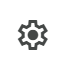

In [20]:
from langchain_core.messages import HumanMessage
message = HumanMessage(content=[
        {"type": "text", "text": "What is in this image?"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{image_data}"},
        },
    ],
)
message

In [22]:
llm.invoke([message], config={"component_id": "test"})

AIMessage(content="This image shows a simple gear or cog icon/symbol. It's a common symbol used to represent settings, tools, configurations, or mechanical/technical functions in user interfaces and applications.", additional_kwargs={}, response_metadata={'id': 'msg_012ZzLTuwT7imqqZrxS2tLDr', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 25, 'output_tokens': 41}}, id='run-cca685a6-3fe6-4521-86c4-80073141300a-0', usage_metadata={'input_tokens': 25, 'output_tokens': 41, 'total_tokens': 66, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})